In [228]:
import os
import ast
import pandas as pd
import pennylane as qml
import matplotlib.pyplot as plt

from pennylane import numpy as np

from pennylane.optimize import SPSAOptimizer
from pennylane.optimize import AdamOptimizer
from pennylane.optimize import GradientDescentOptimizer
from pennylane.optimize import NesterovMomentumOptimizer

from sklearn import cluster
from sklearn import preprocessing

from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances, pairwise_kernels, pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel as sklearn_rbf_kernel

from sklearn.decomposition._pca import PCA

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons, make_blobs, make_circles

plt.style.use('dark_background')

seed = 42

np.random.seed(seed)

# Circuit

In [229]:
def angle_embedding(x, wires):
    for i in wires:
        if i % 2 == 0:
            qml.RY(x[0] * np.pi, wires=i)
        else:
            qml.RX(x[1] * np.pi, wires=i)

# Ampliture Embedding
def amplitude_embedding(x, wires):
    qml.AmplitudeEmbedding(features=x, pad_with=2, wires=wires, normalize=True)

# Minimally Expressive Embedding (4 qubits, replicação de dados)
def minimally_expressive_embedding(x, wires):
    for i in wires:
        if i % 2 == 0:
            qml.RX(x[0] * 2 * np.pi, wires=wires[i])
            qml.RY(np.pi / 4, wires=wires[i])
            qml.RZ(np.pi / 4, wires=wires[i])   
        else:
            qml.RX(x[1] * 2 * np.pi, wires=wires[i])
            qml.RY(np.pi / 4, wires=wires[i])
            qml.RZ(np.pi / 4, wires=wires[i])

def entanglement(W, n_qubits, n_entanglement):
    for camada in range(len(W)):
        # Aplica rotações em cada qubit para a camada atual
        for qubit in range(n_qubits):
            params = W[camada][qubit]
            qml.Rot(params[0], params[1], params[2], wires=qubit)
        
        # Aplica o entrelaçamento baseado em n_entanglement
        for ent in range(n_entanglement):
            # Alterna o padrão de entrelaçamento com base na camada, ent e qubit
            for q in range(n_qubits - 1):
                if (camada + ent + q) % 2 == 0:
                    controle = q
                    alvo = (q + 1) % n_qubits
                else:
                    controle = (q + 1) % n_qubits
                    alvo = q
                qml.CNOT(wires=[controle, alvo])


def circuit(weights, X, n_quibits, n_entanglement, embedding_type = 'AE'):
    if embedding_type == 'AE':
        angle_embedding(X, wires=range(n_quibits))
    elif embedding_type == 'MEE':
        minimally_expressive_embedding(X, wires=range(n_quibits))
    elif embedding_type == 'AmpE':
        amplitude_embedding(X, wires=range(n_quibits))

    qml.StronglyEntanglingLayers(weights=weights, wires=range(n_quibits))

    # entanglement(weights, n_quibits, n_entanglement)

    # return qml.expval(qml.PauliZ(wires=0))
    return np.array([qml.expval(qml.PauliZ(wires=i)) for i in range(n_quibits)])

def create_device(n_quibits):
    return qml.device("lightning.gpu", wires=n_quibits)

def create_qnode(n_quibits, n_entanglement, embedding_type):
    dev = create_device(n_quibits)

    @qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
    def qnode(weights, X):
        return circuit(weights, X, n_quibits, n_entanglement, embedding_type)

    return qnode

def qvc_classifier(qnode, w, b, X):
    return qnode(w, X) + b

# Loss Function

## RBF Kernel

In [ ]:
def quantum_kernel(X):

    # """Calcula a matriz de kernel quântico."""
    # n_samples = len(X)
    # K = np.zeros((n_samples, n_samples))

    # # Precomputa os embeddings quânticos para todos os pontos

    # # Garante que os embeddings sejam 1D e calcula o produto interno
    # for i in range(n_samples):
    #     for j in range(n_samples):
    #         # Achata os arrays para garantir que sejam 1D
    #         vec_i = X[i].ravel()  # Converte para 1D se necessário
    #         vec_j = X[j].ravel()
    #         K[i, j] = np.dot(vec_i, vec_j)

    # return K

    # print(X.shape)
    kernel = np.dot(X, X.T)
    return kernel
    # # print(kernel)
    # # for i in range(len(X)):
    # #     for j in range(len(X)):
    # #         # print(kernel[0, 0])
    # #         print(kernel.shape)
    # #         print(X[i].shape, X[j].shape)
    # #         print(type(X[i] @ X[j]))
    # #         dot = X[i] @ X[j]
    # #         kernel[i, j] = dot
    # return kernel
    # # X = X - np.mean(X, axis = 1, keepdims = True)
    # # return (X @ X.T) / (X.shape[1] - 1)

## Quantum Kmeans

In [231]:
def q_kmeans(X, n_clusters):
    centroids = [X[np.random.randint(X.shape[0])]]

    for _ in range(n_clusters - 1):
        dists = np.array(
            [min(np.linalg.norm(x - c)**2 for c in centroids) for x in X]
        )

        probs = dists / dists.sum()

        centroids.append(X[np.argmax(probs)])

    return np.array(centroids)

## Function

In [ ]:
def cost_function(
    weights,       # Parâmetros do circuito quântico
    bias,          # Viés do circuito
    centroids,     # Centroids
    qnode,         # Circuito quântico (QNode)
    X,             # Dados originais (n x d)
    n_clusters,    # Número de Clusters
):
    X_q = np.array([qvc_classifier(qnode=qnode, w=weights, b=bias, X=x) for x in X])

    # X_q = PCA(n_components=2).fit_transform(X_q)

    X_q = (X_q - np.mean(X_q, axis = 0)) / np.std(X_q, axis = 0)

    dists = np.linalg.norm(X_q[:, None] - centroids, axis = 2)

    clusters = np.argmin(dists, axis = 1)

    clusters_indices = [np.where(clusters == j)[0] for j in range(n_clusters)]

    # means = np.mean(X_q, axis = 0)
    # clusters_means = np.array([
    #     np.mean(X_q[indices], axis = 0) for indices in clusters_indices 
    # ])
    # S_W = sum([quantum_kernel(X_q[indices]) for indices in clusters_indices])
    # S_B = sum([len(indices)*np.outer((mean - means), (mean - means)) for indices, mean in zip(clusters_indices, clusters_means)])

    # fisher_ratio = np.trace(S_B) / (np.trace(S_W) + 1e-8)

    # Passo 2: Calcular a matriz de kernel quântico centralizada
    K = quantum_kernel(X_q)
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

    # Passo 3: Calcular S_W corretamente no espaço completo
    S_W = np.zeros((n, n))
    for j in range(n_clusters):
        indices = clusters_indices[j]
        n_j = len(indices)
        
        if n_j == 0:
            continue  # Ignora clusters vazios
            
        # Máscara para o cluster j
        mask = np.zeros(n, dtype=bool)
        mask[indices] = True
        
        # Matriz de uns para o cluster j
        one_j = np.ones((n_j, n_j)) / n_j
        
        # Centraliza o kernel do cluster j
        K_cluster = K_centered[indices][:, indices]
        K_cluster_centered = K_cluster - one_j @ K_cluster - K_cluster @ one_j + one_j @ K_cluster @ one_j
        
        # # Projeta de volta para o espaço completo
        S_W_cluster = np.zeros((n, n))

        # print(K_cluster_centered.shape, type(K_cluster_centered), K_cluster_centered)
        # print(S_W_cluster[np.ix_(indices, indices)].shape, type(S_W_cluster[np.ix_(indices, indices)]), S_W_cluster[np.ix_(indices, indices)])
        S_W_cluster[np.ix_(indices, indices)] = K_cluster_centered._value
        
        # B = np.zeros((n, n), dtype=K_cluster_centered.dtype)
        # print(B)
        # B[:n, :n] = K_cluster_centered

        S_W += S_W_cluster
        # S_W += S_W_cluster

    # Passo 4: Calcular S_B
    S_B = np.zeros((n, n))
    overall_mean = np.mean(K_centered, axis=0)
    for j in range(n_clusters):
        indices = clusters_indices[j]
        n_j = len(indices)
        if n_j == 0:
            continue
            
        cluster_mean = np.mean(K_centered[indices], axis=0)
        diff = cluster_mean - overall_mean
        S_B += n_j * np.outer(diff, diff)

    # Passo 5: Calcular a razão de Fisher
    fisher_ratio = np.trace(S_B) / (np.trace(S_W) + 1e-8)

    return - fisher_ratio

## Cluster Assingment

In [233]:
def cluster_assigment(qnode, weights,bias, centroids, X):
    X_q = np.array([qvc_classifier(qnode=qnode, w=weights, b=bias, X=x) for x in X])

    # X_q = PCA(n_components=2).fit_transform(X_q)

    X_q = (X_q - np.mean(X_q, axis = 0)) / np.std(X_q, axis = 0)

    dists = np.linalg.norm(X_q[:, None] - centroids, axis = 2)

    clusters = np.argmin(dists, axis = 1)

    return clusters


# Train

In [242]:
def fit(
    qnode, 
    features,
    n_params,
    n_qubits,
    n_layers,
    n_clusters,
    weight_init_max, 
    optimizer,
    dic_optimizer,
    iterations=100, 
    batch_size=32
):
    # Split data into 70% training and 30% validation
    X_train, X_val = train_test_split(features, test_size=0.3, shuffle=True, random_state=seed)

    all_costs = []  # To store cost values
    all_iterations = []

    # Initialize optimizer
    opt = optimizer(**dic_optimizer)
    
    # Initialize weights and bias with uniform distribution
    weights_init = np.random.uniform(
        -weight_init_max, weight_init_max, 
        (n_layers, n_qubits, n_params), 
        requires_grad=True
    )
    bias_init = np.array(0.0, requires_grad=True)
    centroids_init = np.random.rand(n_clusters, n_qubits)

    weights = weights_init
    bias = bias_init
    centroids = centroids_init

    predictions_val = cluster_assigment(
        qnode=qnode,
        weights=weights,
        bias=bias,
        centroids=centroids,
        X=features
        # n_clusters=n_clusters
    )

    plt.figure()
    
    # Plot dados originais
    # plt.subplot(121)
    plt.scatter(features[:,0], features[:,1], c=predictions_val)
    plt.title("Clustering")
    
    plt.show()

    qml.draw_mpl(qnode)(weights, features[0])

    training_info = { 
        "best_weights": weights,
        "best_bias": bias,
        "best_cost": float('inf'),
        "silhouette": None,
        "davies_bouldin": None,
        "calinski_harabasz": None
    }

    patience = 25
    no_improvement = 0

    # Training loop
    for it in range(iterations):
        # Mini-batch sampling (ensure batch_size doesn't exceed training data size)
        current_batch_size = min(batch_size, len(X_train))

        batch_index = np.random.choice(len(X_train), current_batch_size, replace=False)
        X_train_batch = X_train[batch_index]

        wrapped_cost_function = lambda weights, bias, centroids: cost_function(weights, bias, centroids, qnode, X_train_batch, n_clusters)

        # Train model on batch
        params = [weights, bias, centroids]
        (weights, bias, centroids), iteration_cost = opt.step_and_cost(wrapped_cost_function, *params)
        
        # Update best weights and bias if cost improves
        if iteration_cost < training_info['best_cost']:
            training_info['best_weights'] = weights
            training_info['best_bias'] = bias
            training_info['best_centroids'] = centroids
            training_info['best_cost'] = iteration_cost
            no_improvement = 0
        else:
            no_improvement += 1

        all_costs.append(iteration_cost)
        all_iterations.append(it + 1)        

        print(f"Iter: {it + 1:5d} | Cost: {iteration_cost:0.7f} | Best Cost: {training_info['best_cost']:0.7f}")

        # Early stopping if no improvement
        if no_improvement >= patience:
            break


    predictions_val = cluster_assigment(
        qnode=qnode,
        weights=training_info['best_weights'],
        bias=training_info['best_bias'],
        centroids=training_info['best_centroids'],
        X=X_val
        # n_clusters=n_clusters
    )

    plt.figure()

    plt.scatter(X_val[:,0], X_val[:,1], c=predictions_val)
    plt.title("Clustering")
    
    plt.show()

    if len(np.unique(predictions_val)) > 1:
        training_info['davies_bouldin'] = davies_bouldin_score(X_val, predictions_val)
        training_info['calinski_harabasz'] = calinski_harabasz_score(X_val, predictions_val)
        training_info['silhouette'] = silhouette_score(X_val, predictions_val)

    return (all_costs,
            training_info["best_cost"], 
            training_info["best_weights"], 
            training_info["best_bias"], 
            training_info["best_centroids"], 
            training_info["silhouette"], 
            training_info["davies_bouldin"], 
            training_info["calinski_harabasz"])

# Normalize Data

In [235]:
def normalize_data_transformY(X, y, range_init, range_end, plot=True):
  X_scaled = preprocessing.normalize(X,axis=0)

  scaler = preprocessing.MinMaxScaler(feature_range=(range_init, range_end))
  X_scaled = scaler.fit_transform(X)

  X = X_scaled

  if y is not None:
    y = 2*y - 1

  if plot:
    plt.figure(figsize=(4, 4))
    plt.title("Base de dados", fontsize="small")
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=25, c=y if y is not None else None, edgecolor="k")
    plt.show()

  return X_scaled, y

# Moons

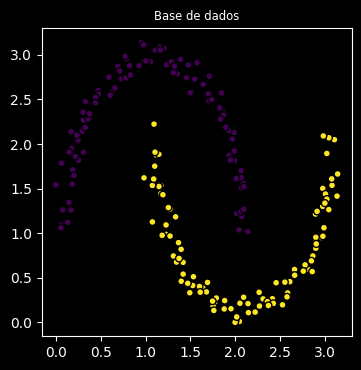

In [236]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=seed)

X, y = normalize_data_transformY(X, y, range_init=0, range_end=np.pi)

# Execution

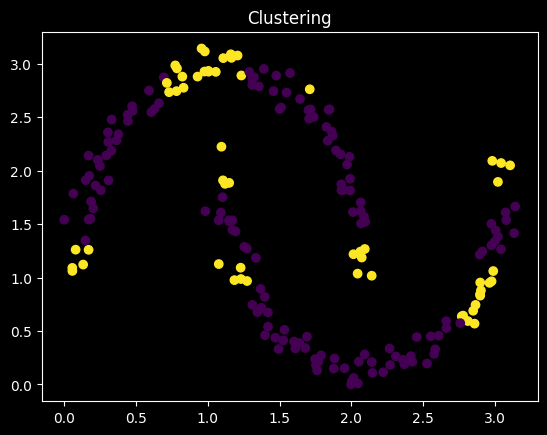

Iter:     1 | Cost: -25.5910675 | Best Cost: -25.5910675
Iter:     2 | Cost: -16.4439858 | Best Cost: -25.5910675
Iter:     3 | Cost: -8.0866399 | Best Cost: -25.5910675
Iter:     4 | Cost: -11.9594838 | Best Cost: -25.5910675
Iter:     5 | Cost: -17.3084168 | Best Cost: -25.5910675
Iter:     6 | Cost: -6.4242050 | Best Cost: -25.5910675
Iter:     7 | Cost: -21.5569304 | Best Cost: -25.5910675
Iter:     8 | Cost: -28.8641076 | Best Cost: -28.8641076
Iter:     9 | Cost: -25.9528926 | Best Cost: -28.8641076
Iter:    10 | Cost: -1.3339914 | Best Cost: -28.8641076
Iter:    11 | Cost: -19.1828802 | Best Cost: -28.8641076
Iter:    12 | Cost: -10.8905771 | Best Cost: -28.8641076
Iter:    13 | Cost: -8.3433340 | Best Cost: -28.8641076
Iter:    14 | Cost: -9.9938427 | Best Cost: -28.8641076
Iter:    15 | Cost: -20.5666645 | Best Cost: -28.8641076
Iter:    16 | Cost: -14.4139727 | Best Cost: -28.8641076
Iter:    17 | Cost: -7.1722073 | Best Cost: -28.8641076
Iter:    18 | Cost: -46.6742383 | Bes

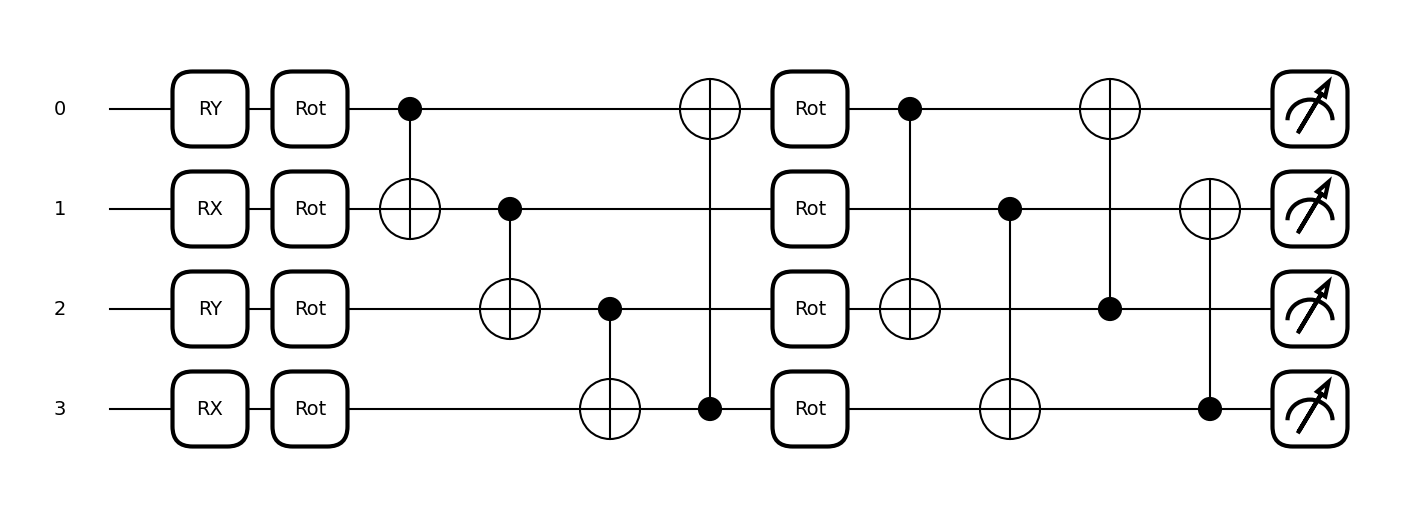

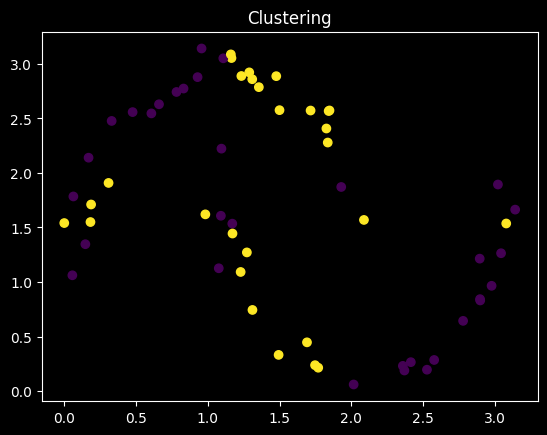

In [246]:
n_qubits = 4
n_params = 3
n_layers = 2
n_clusters = 2
n_entanglement = 1
embedding_type = 'AE'
qnode = create_qnode(n_qubits, n_entanglement=n_entanglement, embedding_type=embedding_type)

all_costs, cost, weights, bias, centroids, score_silhouette, score_davies, score_calinski = fit(
    qnode=qnode,
    features=X,
    n_params=n_params,
    n_qubits=n_qubits,
    n_layers=n_layers,
    n_clusters=n_clusters,
    weight_init_max=np.pi,
    optimizer=GradientDescentOptimizer,
    # dic_optimizer={"maxiter": 100},
    dic_optimizer={"stepsize": 0.1},
    iterations=100,
    batch_size=32
)